# 🎤 OIIAIOIIIAI 元音识别 CNN 训练

本 notebook 用于训练一个轻量级 CNN 模型，识别 5 个元音 (A/E/I/O/U) + 静音。

虽然目标用户是中文用户，但是比较靠谱的数据集只找到了基于英文的 TIMIT，我寻思应该也差不多，反正 oiia 猫本身就是从英文音频采样的

## 特点
- **输入**: 210ms 原始波形 (3360 samples @ 16kHz)
- **特征**: Mel 频谱提取层集成在模型内部
- **输出**: TensorFlow.js 格式，可直接在浏览器运行
- **大小**: ~100KB (量化后)

## 使用方法
1. 将 TIMIT 数据集上传到 Google Drive
2. 按顺序运行所有 cell
3. 下载生成的 `tfjs_model/` 文件夹

## 1. 环境配置

In [31]:
!rm -rf /content/vowel_training

In [32]:
# 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# 安装必要的包（只执行一次）
import subprocess
import sys

def is_installed(pkg):
    try:
        __import__(pkg)
        return True
    except ImportError:
        return False

if not is_installed('tensorflowjs') or not is_installed('soundfile'):
    subprocess.run([sys.executable, '-m', 'pip', 'uninstall', '-y', 'kaggle', 'kagglesdk'], capture_output=True)
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'kagglesdk', '-U'], capture_output=True)
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'kaggle', '-U'], capture_output=True)
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'soundfile', 'tensorflowjs'], capture_output=True)
    print("✅ 包安装完成")
else:
    print("✅ 包已安装，跳过")

✅ 包已安装，跳过


In [34]:
from google.colab import userdata

# Get Kaggle API Token and set as environment variable
kaggle_token = userdata.get('KAGGLE_API_TOKEN')
if kaggle_token:
    !export KAGGLE_API_TOKEN='{kaggle_token}'
    print("KAGGLE_API_TOKEN has been set as an environment variable.")
else:
    print("Warning: KAGGLE_API_TOKEN not found in Userdata. Please ensure it's set.")

!kaggle competitions list

KAGGLE_API_TOKEN has been set as an environment variable.
Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [35]:
import os
import glob

# Define paths for download and extraction
download_path = '/content/kaggle_downloads'
timit_extracted_path = '/content/timit_data'
dataset_slug = 'mfekadu/darpa-timit-acousticphonetic-continuous-speech'

# Create directories
os.makedirs(download_path, exist_ok=True)
os.makedirs(timit_extracted_path, exist_ok=True)

# Download the dataset using kaggle CLI
print(f"Downloading Kaggle dataset: {dataset_slug} to {download_path}...")
# Use the -p flag to specify download path
!kaggle datasets download {dataset_slug} -p {download_path}

# Determine the exact zip file name (it's often the last part of the slug)
expected_zip_name = dataset_slug.split('/')[-1] + '.zip'
zip_file = os.path.join(download_path, expected_zip_name)

# If the exact zip file name isn't found, try to find any zip file in the download_path
if not os.path.exists(zip_file):
    zip_files = glob.glob(os.path.join(download_path, '*.zip'))
    if zip_files:
        zip_file = zip_files[0] # Take the first one found
        print(f"Found zip file: {zip_file}")
    else:
        raise FileNotFoundError(f"No zip file found in {download_path} after download.")

# Unzip the downloaded dataset
print(f"Unzipping dataset '{os.path.basename(zip_file)}' to {timit_extracted_path}...")
!unzip -o -q {zip_file} -d {timit_extracted_path}

# The dataset typically unzips into a folder with the same name as the last part of the slug
final_timit_root = os.path.join(timit_extracted_path, dataset_slug.split('/')[-1])

print("\n✅ Kaggle dataset downloaded and unzipped successfully.")
print(f"The TIMIT dataset root is located at: {final_timit_root}")
print("\n⚠️ Please remember to update the 'TIMIT_DIR' variable in the next '## 2. 配置参数' section (cell 'f4ec19f5') to this path:")
print(f"   TIMIT_DIR = '{final_timit_root}'")


Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
darpa-timit-acousticphonetic-continuous-speech.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzipping dataset 'darpa-timit-acousticphonetic-continuous-speech.zip' to /content/timit_data...

✅ Kaggle dataset downloaded and unzipped successfully.
The TIMIT dataset root is located at: /content/timit_data/darpa-timit-acousticphonetic-continuous-speech

⚠️ Please remember to update the 'TIMIT_DIR' variable in the next '## 2. 配置参数' section (cell 'f4ec19f5') to this path:
   TIMIT_DIR = '/content/timit_data/darpa-timit-acousticphonetic-continuous-speech'


In [36]:
# 检查 GPU
!nvidia-smi

import tensorflow as tf
print(f"\nTensorFlow 版本: {tf.__version__}")
print(f"GPU 可用: {tf.config.list_physical_devices('GPU')}")

Mon Feb  2 11:07:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             31W /   70W |     394MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. 配置参数

⚠️ **重要**: 修改 `TIMIT_DIR` 为你的 TIMIT 数据集路径

In [ ]:
import os
import numpy as np

# ============ 修改这里的路径 ============
TIMIT_DIR = '/content/timit_data/data'  # TIMIT 数据集路径
# ========================================

# 工作目录 (在 Colab 本地)
WORK_DIR = '/content/vowel_training'
DATA_DIR = os.path.join(WORK_DIR, 'data')
CHECKPOINT_DIR = os.path.join(WORK_DIR, 'checkpoints')
OUTPUT_DIR = os.path.join(WORK_DIR, 'output')

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 音频参数
SAMPLE_RATE = 16000           # 16kHz 采样率
FRAME_LENGTH = 400            # 25ms 帧长
FRAME_STEP = 160              # 10ms 帧移
FFT_LENGTH = 512              # FFT 点数
N_MELS = 40                   # Mel 频带数
INPUT_SAMPLES = 3360          # 210ms @ 16kHz

# 元音类别
VOWEL_CLASSES = ['A', 'E', 'I', 'O', 'U', 'silence']
NUM_CLASSES = len(VOWEL_CLASSES)

# 音素到元音的映射 (TIMIT 音素集)
# 参考: https://en.wikipedia.org/wiki/ARPABET
#
# ⚠️ 简化版：只保留最典型、最纯粹的音素
# 目标是中文用户的 A/E/I/O/U 发音
#
PHONEME_TO_VOWEL = {
    # A 类 - /ɑ/, /æ/ 类元音 (father, cat)
    'aa': 'A',   # odd, father - 最典型的 A
    # 'ae': 'A',   # at, cat - /æ/ 太接近 E
    # 'ah': 'A',   # hut, but (schwa 归入 A)
    # 'ax': 'A',   # about (schwa)
    # 'aw': 'A',   # cow, how (双元音以 A 开头)
    # 'ay': 'A',   # hide, my (双元音以 A 开头)

    # E 类 - /ɛ/, /eɪ/ 类元音 (bed, say)
    'eh': 'E',   # red, bed - 最典型的 E
    # 'ey': 'E',   # ate, say - /eɪ/ 双元音，结尾带 I 色彩
    # 'er': 'E',   # bird, her (r-colored)
    # 'axr': 'E',  # butter (r-colored schwa)

    # I 类 - /ɪ/, /i/ 类元音 (bit, beat)
    'iy': 'I',   # eat, beat - 最典型的 I
    # 'ih': 'I',   # it, bit - /ɪ/ 太接近 E
    # 'ix': 'I',   # roses (reduced i)

    # O 类 - /ɔ/, /oʊ/ 类元音 (thought, go)
    'ao': 'O',   # ought, thought, law
    'ow': 'O',   # oat, go
    # 'oy': 'O',   # toy, boy (双元音以 O 开头)

    # U 类 - /ʊ/, /u/ 类元音 (book, boot)
    'uw': 'U',   # two, boot - 最典型的 U
    # 'uh': 'U',   # hood, book - /ʊ/ 太短促
    # 'ux': 'U',   # toot (reduced u)
}

# 训练配置
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10

print("配置完成!")
print(f"TIMIT 路径: {TIMIT_DIR}")
print(f"输出目录: {OUTPUT_DIR}")

# 显示音素映射统计
print(f"\n音素映射统计 (简化版):")
for vowel in VOWEL_CLASSES[:-1]:  # 排除 silence
    phonemes = [p for p, v in PHONEME_TO_VOWEL.items() if v == vowel]
    print(f"  {vowel}: {len(phonemes)} 个音素 - {phonemes}")

配置完成!
TIMIT 路径: /content/timit_data/data
输出目录: /content/vowel_training/output

音素映射统计:
  A: 2 个音素 - ['aa', 'ae']
  E: 2 个音素 - ['eh', 'ey']
  I: 2 个音素 - ['ih', 'iy']
  O: 2 个音素 - ['ao', 'ow']
  U: 2 个音素 - ['uh', 'uw']


## 3. 定义模型

模型包含一个 `MelSpectrogram` 层，将原始波形转换为 Log-Mel 特征。
这确保了 Python 训练和 JavaScript 推理使用完全相同的特征提取。

In [38]:
import tensorflow as tf

def create_mel_filterbank(num_mels=N_MELS, num_spectrogram_bins=FFT_LENGTH // 2 + 1,
                          sample_rate=SAMPLE_RATE, lower_freq=0.0, upper_freq=8000.0):
    """创建 Mel 滤波器组矩阵"""
    return tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mels,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=lower_freq,
        upper_edge_hertz=upper_freq
    ).numpy()


class MelSpectrogram(tf.keras.layers.Layer):
    """
    Mel 频谱提取层 - 将原始波形转换为 Log-Mel 特征
    该层会被导出到 TensorFlow.js，确保训练和推理一致
    """

    def __init__(self, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP,
                 fft_length=FFT_LENGTH, num_mels=N_MELS,
                 sample_rate=SAMPLE_RATE, **kwargs):
        super().__init__(**kwargs)
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.num_mels = num_mels
        self.sample_rate = sample_rate

    def build(self, input_shape):
        mel_filterbank = create_mel_filterbank(
            num_mels=self.num_mels,
            num_spectrogram_bins=self.fft_length // 2 + 1,
            sample_rate=self.sample_rate
        )
        self.mel_filterbank = self.add_weight(
            name='mel_filterbank',
            shape=mel_filterbank.shape,
            initializer=tf.constant_initializer(mel_filterbank),
            trainable=False
        )
        super().build(input_shape)

    def call(self, waveform):
        # STFT
        stft = tf.signal.stft(
            waveform,
            frame_length=self.frame_length,
            frame_step=self.frame_step,
            fft_length=self.fft_length,
            window_fn=tf.signal.hann_window
        )

        # 幅度谱
        magnitude = tf.abs(stft)

        # Mel 滤波
        mel = tf.matmul(magnitude, self.mel_filterbank)

        # 对数压缩
        log_mel = tf.math.log(mel + 1e-6)

        # 添加通道维度 [batch, time, mels, 1]
        return tf.expand_dims(log_mel, -1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'frame_length': self.frame_length,
            'frame_step': self.frame_step,
            'fft_length': self.fft_length,
            'num_mels': self.num_mels,
            'sample_rate': self.sample_rate,
        })
        return config


def create_vowel_model(include_mel_layer=True):
    """
    创建元音识别模型

    Args:
        include_mel_layer: 是否包含 Mel 特征提取层
            - True: 输入原始波形，用于最终导出
            - False: 输入预提取的 Mel 特征，用于加速训练
    """
    # Calculate actual time steps for Mel spectrogram
    # T = (INPUT_SAMPLES - FRAME_LENGTH) / FRAME_STEP + 1
    num_time_steps = int((INPUT_SAMPLES - FRAME_LENGTH) / FRAME_STEP) + 1
    print(f"Calculated Mel spectrogram time steps: {num_time_steps}")

    if include_mel_layer:
        # 完整模型：输入原始波形
        waveform_input = tf.keras.Input(shape=(INPUT_SAMPLES,), name='waveform')
        x = MelSpectrogram(name='mel_spectrogram')(waveform_input)
    else:
        # 训练时使用：输入预提取的 Mel 特征
        # Adjust input shape to match actual Mel feature dimensions (19 time steps)
        x = tf.keras.Input(shape=(num_time_steps, N_MELS, 1), name='mel_input')
        waveform_input = x

    # CNN 分类部分
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(x if include_mel_layer else waveform_input)
    x = tf.keras.layers.BatchNormalization(name='bn1')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name='pool2')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3')(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name='gap')(x)

    x = tf.keras.layers.Dense(32, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.3, name='dropout')(x)

    # 输出：6 类
    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='vowel_output')(x)

    model = tf.keras.Model(inputs=waveform_input, outputs=output, name='vowel_classifier')
    return model


def create_full_model_from_weights(feature_model):
    """从训练好的特征模型创建完整模型（包含 Mel 层）"""
    full_model = create_vowel_model(include_mel_layer=True)

    # 复制权重（跳过 Mel 层）
    for layer in feature_model.layers:
        # Check if the layer exists in the full_model before attempting to set weights
        if layer.name in [l.name for l in full_model.layers]:
            if layer.name not in ['mel_spectrogram', 'waveform', 'mel_input']:
                full_model.get_layer(layer.name).set_weights(layer.get_weights())

    return full_model


# 测试模型创建
print("测试模型创建...")
test_model = create_vowel_model(include_mel_layer=True)
test_model.summary()

测试模型创建...
Calculated Mel spectrogram time steps: 19


Model: "vowel_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ waveform (InputLayer)           │ (None, 3360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mel_spectrogram                 │ (None, 19, 40, 1)      │        10,280 │
│ (MelSpectrogram)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 19, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 19, 40, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 9, 20, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 9, 20, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 9, 20, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 4, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 4, 10, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 4, 10, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vowel_output (Dense)            │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,942 (269.30 KB)

 Trainable params: 58,342 (227.90 KB)

 Non-trainable params: 10,600 (41.41 KB)

## 4. 从 TIMIT 提取元音片段

In [39]:
import glob
import soundfile as sf
from collections import defaultdict
import json

def parse_phn_file(phn_path):
    """解析 .phn 文件，返回音素列表"""
    phonemes = []
    with open(phn_path, 'r', encoding='latin-1') as f: # Added encoding='latin-1'
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3:
                start_sample = int(parts[0])
                end_sample = int(parts[1])
                phoneme = parts[2].lower()
                phonemes.append({
                    'start': start_sample,
                    'end': end_sample,
                    'phoneme': phoneme
                })
    return phonemes


def extract_vowel_segments(wav_path, phn_path, target_samples=INPUT_SAMPLES):
    """改进版：使用能量中心定位元音"""
    try:
        audio = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)[0]
    except:
        try:
            audio, sr = sf.read(wav_path)
            if sr != SAMPLE_RATE:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        except:
            return []

    if audio is None or len(audio) == 0:
        return []

    phonemes = parse_phn_file(phn_path)
    segments = []
    half_context = target_samples // 2

    for ph in phonemes:
        phoneme = ph['phoneme']
        if phoneme not in PHONEME_TO_VOWEL:
            continue

        vowel = PHONEME_TO_VOWEL[phoneme]

        # 获取元音片段
        vowel_start = ph['start']
        vowel_end = ph['end']
        vowel_audio = audio[vowel_start:vowel_end]

        if len(vowel_audio) < 100:  # 太短的跳过
            continue

        # 🔧 改进：使用能量中心而不是标注中心
        # 计算短时能量
        frame_size = 160  # 10ms
        energy = []
        for i in range(0, len(vowel_audio) - frame_size, frame_size):
            frame = vowel_audio[i:i+frame_size]
            energy.append(np.sum(frame ** 2))

        if len(energy) == 0:
            continue

        # 找能量中心（加权平均）
        energy = np.array(energy)
        if np.sum(energy) > 0:
            energy_center_frame = int(np.average(np.arange(len(energy)), weights=energy))
            energy_center = vowel_start + energy_center_frame * frame_size + frame_size // 2
        else:
            energy_center = (vowel_start + vowel_end) // 2

        # 以能量中心为基准提取
        start_idx = energy_center - half_context
        end_idx = energy_center + half_context

        if start_idx < 0 or end_idx > len(audio):
            continue

        segment = audio[start_idx:end_idx]

        if len(segment) != target_samples:
            continue

        segments.append((segment.astype(np.float32), vowel, phoneme))

    return segments


def extract_silence_segments(wav_path, phn_path, target_samples=INPUT_SAMPLES, max_per_file=2):
    """从单个音频文件提取静音片段 - 使用改进的方式"""
    # 使用 librosa 安全加载音频
    try:
        audio = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)[0]
    except Exception as e:
        try:
            audio, sr = sf.read(wav_path)
            if sr != SAMPLE_RATE:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        except Exception as e2:
            return []

    phonemes = parse_phn_file(phn_path)
    segments = []
    half_context = target_samples // 2

    for ph in phonemes:
        phoneme = ph['phoneme']

        if phoneme in PHONEME_TO_VOWEL:
            continue

        # 选择静音/停顿音素
        if phoneme not in ['h#', 'pau', 'epi', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl']:
            continue

        center = (ph['start'] + ph['end']) // 2
        start_idx = center - half_context
        end_idx = center + half_context

        if start_idx < 0 or end_idx > len(audio):
            continue

        segment = audio[start_idx:end_idx]

        if len(segment) != target_samples:
            continue

        segments.append((segment.astype(np.float32), 'silence'))

        if len(segments) >= max_per_file:
            break

    return segments


def find_timit_files(timit_dir):
    """查找所有 TIMIT 音频文件"""
    wav_files = []

    for subset in ['TRAIN', 'TEST', 'train', 'test']:
        subset_dir = os.path.join(timit_dir, subset)

        if not os.path.exists(subset_dir):
            continue

        for ext in ['*.WAV', '*.wav']:
            pattern = os.path.join(subset_dir, '**', ext)
            wav_files.extend(glob.glob(pattern, recursive=True))

    return list(set(wav_files))


def get_speaker_id(wav_path):
    """从路径提取说话者 ID"""
    parts = wav_path.replace('\\', '/').split('/')
    for i, part in enumerate(parts):
        if part.startswith('DR') and i + 1 < len(parts):
            return parts[i + 1]
    return os.path.basename(os.path.dirname(wav_path))


print("函数定义完成!")

函数定义完成!


In [40]:
# 执行元音提取
print("=" * 60)
print("TIMIT 元音提取")
print("=" * 60)

# 查找所有音频文件
print(f"\n查找 TIMIT 文件: {TIMIT_DIR}")
wav_files = find_timit_files(TIMIT_DIR)
print(f"找到 {len(wav_files)} 个音频文件")

if len(wav_files) == 0:
    print("\n❌ 错误: 未找到任何音频文件!")
    print("请确保 TIMIT 数据集位于:", TIMIT_DIR)
    print("目录结构应为: timit/TRAIN/DR*/SPEAKER/*.WAV")
    raise Error()

# 按说话者分组
speaker_files = defaultdict(list)
for wav_path in wav_files:
    speaker = get_speaker_id(wav_path)
    speaker_files[speaker].append(wav_path)

print(f"共 {len(speaker_files)} 个说话者")

# 提取所有片段
all_segments = defaultdict(list)

from tqdm import tqdm

for speaker, files in tqdm(speaker_files.items(), desc="提取中"):
    for wav_path in files:
        # 找到对应的 .phn 文件 - 尝试多种路径格式
        phn_path = wav_path.rsplit('.', 1)[0] + '.phn'
        if not os.path.exists(phn_path):
            # 尝试替换扩展名（TIMIT可能有不同格式）
            phn_path = wav_path.replace('.WAV', '.PHN').replace('.wav', '.phn')
            if not os.path.exists(phn_path):
                continue

        # 提取元音片段（改进版：仅提取音素范围 + zero-padding）
        vowel_segments = extract_vowel_segments(wav_path, phn_path)
        for segment, vowel, phoneme in vowel_segments:
            all_segments[vowel].append((segment, speaker, phoneme))

        # 提取静音片段（使用改进方式）
        silence_segments = extract_silence_segments(wav_path, phn_path)
        for segment, vowel in silence_segments:
            all_segments[vowel].append((segment, speaker, 'silence'))

# 统计
print("\n提取结果:")
print("-" * 40)
total = 0
for vowel in VOWEL_CLASSES:
    count = len(all_segments[vowel])
    print(f"  {vowel}: {count} 个样本")
    total += count
print("-" * 40)
print(f"  总计: {total} 个样本")

TIMIT 元音提取

查找 TIMIT 文件: /content/timit_data/data
找到 12600 个音频文件
共 630 个说话者


提取中: 100%|██████████| 630/630 [00:14<00:00, 43.53it/s]


提取结果:
----------------------------------------
  A: 9601 个样本
  E: 8381 个样本
  I: 16423 个样本
  O: 7009 个样本
  U: 1481 个样本
  silence: 12350 个样本
----------------------------------------
  总计: 55245 个样本


一些检测

📊 元音共振峰 (F1-F2) 分布分析

分析 A 类 (300 个样本)...

分析 E 类 (300 个样本)...

分析 I 类 (300 个样本)...

分析 O 类 (300 个样本)...

分析 U 类 (300 个样本)...

--------------------------------------------------
📈 共振峰统计 (Hz):
--------------------------------------------------
元音       F1 均值        F1 标准差       F2 均值        F2 标准差       样本数
--------------------------------------------------
A        699          82           1349         300          300
E        584          77           1562         287          300
I        477          79           1683         399          300
O        619          83           1094         169          300
U        478          64           1285         241          300


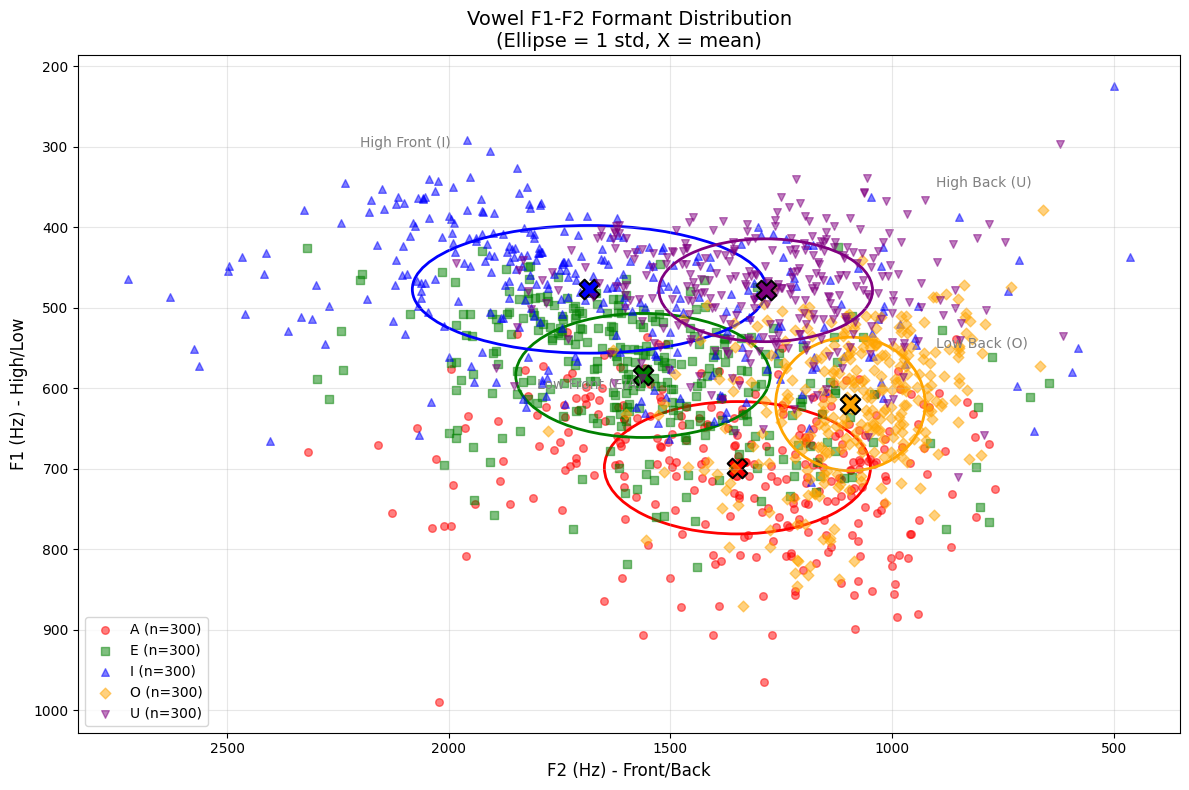


✅ F1-F2 分布图已保存

--------------------------------------------------
📚 参考: 典型英语元音共振峰范围 (Hz)
--------------------------------------------------
元音    F1 范围        F2 范围        特征
--------------------------------------------------
I       270-310        2200-2800      高前元音
E       500-700        1700-2100      中前元音
A       700-1000       1100-1400      低元音
O       500-700        800-1100       中后元音
U       300-400        800-1200       高后元音
--------------------------------------------------


In [41]:
import librosa
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming  # scipy >= 1.1 移到了 windows 子模块
from scipy.linalg import solve_toeplitz
import numpy as np

def estimate_formants(audio, sr=SAMPLE_RATE, num_formants=3):
    """
    使用 LPC 方法估计共振峰 (F1, F2, F3)

    Args:
        audio: 音频信号
        sr: 采样率
        num_formants: 要估计的共振峰数量

    Returns:
        formants: 共振峰频率列表 [F1, F2, F3, ...]
    """
    # 预加重
    pre_emphasis = 0.97
    emphasized = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

    # 加窗
    windowed = emphasized * hamming(len(emphasized))

    # LPC 分析 (阶数 = 2 + 采样率/1000)
    lpc_order = int(2 + sr / 1000)

    # 计算自相关
    autocorr = np.correlate(windowed, windowed, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # Levinson-Durbin 递推求 LPC 系数
    r = autocorr[:lpc_order + 1]
    if r[0] == 0:
        return [0] * num_formants

    # 使用 Toeplitz 求解
    try:
        a = solve_toeplitz(r[:-1], -r[1:])
        a = np.concatenate([[1], a])
    except:
        return [0] * num_formants

    # 求根
    roots = np.roots(a)

    # 只保留单位圆内、正频率的根
    roots = roots[np.imag(roots) >= 0]
    roots = roots[np.abs(roots) < 1]

    # 转换为频率
    angles = np.arctan2(np.imag(roots), np.real(roots))
    freqs = angles * (sr / (2 * np.pi))

    # 排序并过滤合理范围内的频率
    freqs = sorted([f for f in freqs if 90 < f < 5000])

    # 返回前 num_formants 个共振峰
    formants = freqs[:num_formants] if len(freqs) >= num_formants else freqs + [0] * (num_formants - len(freqs))

    return formants


def analyze_vowel_formants(all_segments, sample_size=200):
    """
    分析各类元音的 F1-F2 分布

    Args:
        all_segments: 提取的元音片段字典
        sample_size: 每类采样数量
    """
    print("="*60)
    print("📊 元音共振峰 (F1-F2) 分布分析")
    print("="*60)

    formant_data = {vowel: {'F1': [], 'F2': []} for vowel in VOWEL_CLASSES if vowel != 'silence'}

    for vowel in VOWEL_CLASSES:
        if vowel == 'silence' or vowel not in all_segments:
            continue

        segments = all_segments[vowel]
        if not segments:
            continue

        # 随机采样
        np.random.seed(42)
        sample_indices = np.random.choice(len(segments), min(sample_size, len(segments)), replace=False)

        print(f"\n分析 {vowel} 类 ({len(sample_indices)} 个样本)...")

        for idx in sample_indices:
            audio = segments[idx][0]

            # 提取中心区域（元音最稳定的部分）
            center_start = len(audio) // 4
            center_end = 3 * len(audio) // 4
            center_audio = audio[center_start:center_end]

            formants = estimate_formants(center_audio, SAMPLE_RATE)

            if len(formants) >= 2 and formants[0] > 0 and formants[1] > 0:
                formant_data[vowel]['F1'].append(formants[0])
                formant_data[vowel]['F2'].append(formants[1])

    # 统计各元音的 F1-F2 均值和标准差
    print("\n" + "-"*50)
    print("📈 共振峰统计 (Hz):")
    print("-"*50)
    print(f"{'元音':<8} {'F1 均值':<12} {'F1 标准差':<12} {'F2 均值':<12} {'F2 标准差':<12} {'样本数'}")
    print("-"*50)

    for vowel in ['A', 'E', 'I', 'O', 'U']:
        if vowel in formant_data and formant_data[vowel]['F1']:
            f1_mean = np.mean(formant_data[vowel]['F1'])
            f1_std = np.std(formant_data[vowel]['F1'])
            f2_mean = np.mean(formant_data[vowel]['F2'])
            f2_std = np.std(formant_data[vowel]['F2'])
            n = len(formant_data[vowel]['F1'])
            print(f"{vowel:<8} {f1_mean:<12.0f} {f1_std:<12.0f} {f2_mean:<12.0f} {f2_std:<12.0f} {n}")

    # 绘制 F1-F2 元音图
    plt.figure(figsize=(12, 8))

    colors = {'A': 'red', 'E': 'green', 'I': 'blue', 'O': 'orange', 'U': 'purple'}
    markers = {'A': 'o', 'E': 's', 'I': '^', 'O': 'D', 'U': 'v'}

    for vowel in ['A', 'E', 'I', 'O', 'U']:
        if vowel in formant_data and formant_data[vowel]['F1']:
            f1 = formant_data[vowel]['F1']
            f2 = formant_data[vowel]['F2']
            plt.scatter(f2, f1, c=colors[vowel], marker=markers[vowel],
                       alpha=0.5, s=30, label=f'{vowel} (n={len(f1)})')

            # 绘制椭圆（1个标准差）
            from matplotlib.patches import Ellipse
            mean_f1, mean_f2 = np.mean(f1), np.mean(f2)
            std_f1, std_f2 = np.std(f1), np.std(f2)
            ellipse = Ellipse((mean_f2, mean_f1), 2*std_f2, 2*std_f1,
                             fill=False, edgecolor=colors[vowel], linewidth=2)
            plt.gca().add_patch(ellipse)

            # 标注均值点
            plt.scatter([mean_f2], [mean_f1], c=colors[vowel], marker='X', s=200,
                       edgecolors='black', linewidths=1.5)

    # 反转轴（语音学惯例：F1高在下，F2高在左）
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.xlabel('F2 (Hz) - Front/Back', fontsize=12)
    plt.ylabel('F1 (Hz) - High/Low', fontsize=12)
    plt.title('Vowel F1-F2 Formant Distribution\n(Ellipse = 1 std, X = mean)', fontsize=14)
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)

    # 添加参考区域标注
    plt.annotate('High Front (I)', xy=(2200, 300), fontsize=10, color='gray')
    plt.annotate('Low Front (E/A)', xy=(1800, 600), fontsize=10, color='gray')
    plt.annotate('High Back (U)', xy=(900, 350), fontsize=10, color='gray')
    plt.annotate('Low Back (O)', xy=(900, 550), fontsize=10, color='gray')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'vowel_formant_distribution.png'), dpi=150)
    plt.show()

    print("\n✅ F1-F2 分布图已保存")

    # 参考值对比
    print("\n" + "-"*50)
    print("📚 参考: 典型英语元音共振峰范围 (Hz)")
    print("-"*50)
    print("元音    F1 范围        F2 范围        特征")
    print("-"*50)
    print("I       270-310        2200-2800      高前元音")
    print("E       500-700        1700-2100      中前元音")
    print("A       700-1000       1100-1400      低元音")
    print("O       500-700        800-1100       中后元音")
    print("U       300-400        800-1200       高后元音")
    print("-"*50)

    return formant_data


# 执行分析
formant_data = analyze_vowel_formants(all_segments, sample_size=300)

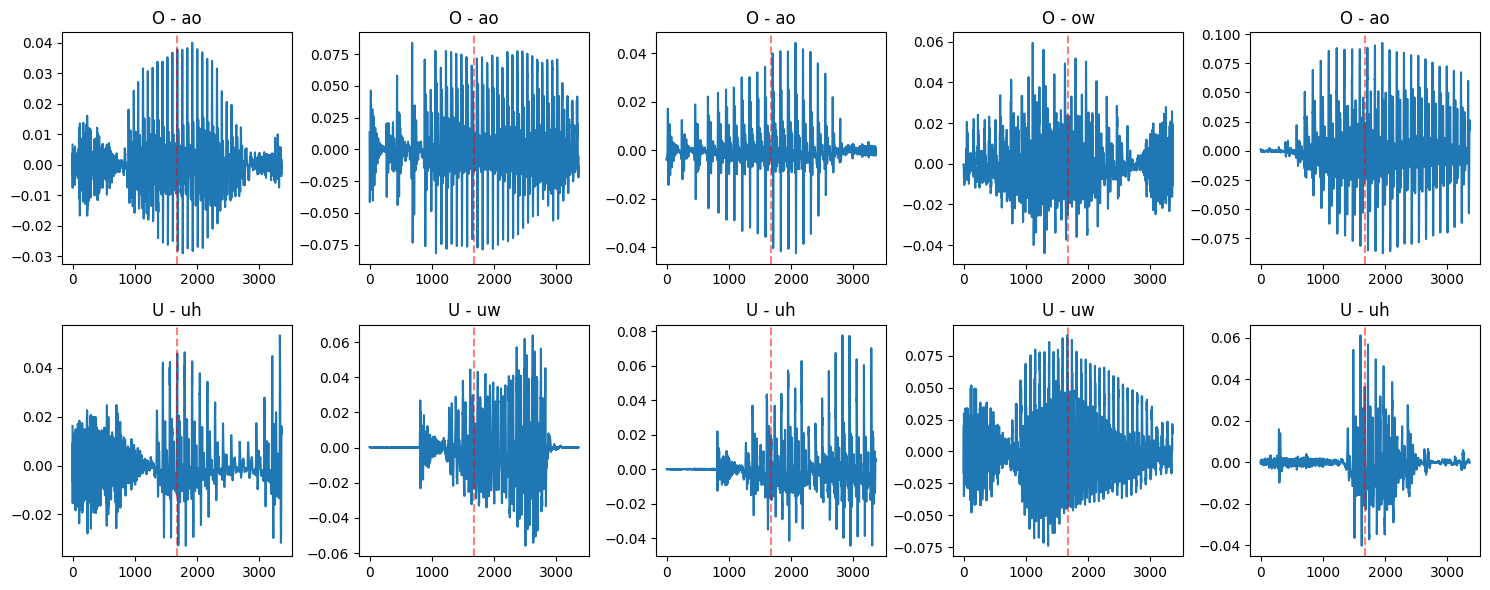

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 诊断：分析各类样本的质量
print("="*60)
print("📊 样本质量诊断")
print("="*60)

def analyze_sample_quality(segments, vowel_name):
    """分析样本的能量分布和质量"""
    if not segments:
        return None

    energies = []
    center_energies = []  # 中心区域能量
    edge_energies = []    # 边缘区域能量

    for seg in segments:
        audio = seg[0]
        total_energy = np.sum(audio ** 2)
        energies.append(total_energy)

        # 中心 1/3
        center_start = len(audio) // 3
        center_end = 2 * len(audio) // 3
        center_energy = np.sum(audio[center_start:center_end] ** 2)
        center_energies.append(center_energy)

        # 边缘
        edge_energy = total_energy - center_energy
        edge_energies.append(edge_energy)

    energies = np.array(energies)
    center_energies = np.array(center_energies)
    edge_energies = np.array(edge_energies)

    # 中心能量占比
    center_ratio = center_energies / (energies + 1e-10)

    return {
        'count': len(segments),
        'mean_energy': np.mean(energies),
        'std_energy': np.std(energies),
        'mean_center_ratio': np.mean(center_ratio),
        'low_center_ratio_count': np.sum(center_ratio < 0.3),  # 中心能量太低的样本数
    }

print("\n各类样本统计:")
print("-"*70)
print(f"{'类别':<8} {'数量':<10} {'平均能量':<15} {'中心能量占比':<15} {'低质量样本'}")
print("-"*70)

for vowel in VOWEL_CLASSES:
    if vowel not in all_segments or not all_segments[vowel]:
        print(f"{vowel:<8} 无数据")
        continue

    stats = analyze_sample_quality(all_segments[vowel], vowel)
    if stats:
        print(f"{vowel:<8} {stats['count']:<10} {stats['mean_energy']:<15.4f} "
              f"{stats['mean_center_ratio']:<15.2%} {stats['low_center_ratio_count']}")

# 可视化各类波形
print("\n" + "="*60)
print("📈 各类样本波形对比")
print("="*60)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, vowel in enumerate(['I', 'E']):  # 重点看 I 和 E
    segments = all_segments.get(vowel, [])
    if not segments:
        continue

    np.random.seed(42)
    sample_indices = np.random.choice(len(segments), min(5, len(segments)), replace=False)

    for i, si in enumerate(sample_indices):
        audio = segments[si][0]
        phoneme = segments[si][2] if len(segments[si]) > 2 else '?'

        axes[idx, i].plot(audio, linewidth=0.5)
        axes[idx, i].set_title(f'{vowel} - {phoneme}')
        axes[idx, i].axvline(len(audio)//2, color='r', linestyle='--', alpha=0.5, label='center')

        # 标注中心 1/3 区域
        center_start = len(audio) // 3
        center_end = 2 * len(audio) // 3
        axes[idx, i].axvspan(center_start, center_end, alpha=0.2, color='green')

        # 计算中心能量占比
        total_e = np.sum(audio ** 2)
        center_e = np.sum(audio[center_start:center_end] ** 2)
        ratio = center_e / (total_e + 1e-10)
        axes[idx, i].set_xlabel(f'center: {ratio:.1%}')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_quality_check.png'), dpi=150)
plt.show()

# 检查 I 类的音素来源
print("\n" + "="*60)
print("🔍 I 类音素来源分析")
print("="*60)

if 'I' in all_segments:
    i_phonemes = [seg[2] for seg in all_segments['I'] if len(seg) > 2]
    from collections import Counter
    phoneme_counts = Counter(i_phonemes)
    print(f"I 类包含的音素: {dict(phoneme_counts)}")

    # 检查原始标注中 iy 的时长分布
    print("\n检查 iy 音素的原始时长...")

人工二次确认取样没啥问题

In [43]:
import shutil
from google.colab import files

# 下载样本进行人工听辨验证
print("\n打包样本进行验证...")

sample_output_dir = os.path.join(OUTPUT_DIR, 'samples_for_check')
os.makedirs(sample_output_dir, exist_ok=True)

num_samples_to_save = 5

for vowel in VOWEL_CLASSES:
    if vowel not in all_segments:
        continue

    segments = all_segments[vowel]
    if not segments:
        continue

    vowel_dir = os.path.join(sample_output_dir, vowel)
    os.makedirs(vowel_dir, exist_ok=True)

    for i, (segment, speaker, phoneme) in enumerate(segments[:num_samples_to_save]):
        # 直接保存完整的 210ms 片段（包含上下文，与推理时一致）
        sample_filepath = os.path.join(vowel_dir, f'{vowel}_{phoneme}_{speaker}_{i:03d}.wav')
        sf.write(sample_filepath, segment, SAMPLE_RATE)

# 打包
samples_zip = os.path.join(OUTPUT_DIR, 'samples_for_check.zip')
shutil.make_archive(sample_output_dir, 'zip', sample_output_dir)
files.download(samples_zip)

print(f"✅ 样本已打包: {samples_zip}")
print(f"   大小: {os.path.getsize(samples_zip) / 1024:.1f} KB")
print(f"\n📝 说明:")
print(f"   每个样本都是完整的 210ms ({INPUT_SAMPLES} samples @ {SAMPLE_RATE}Hz)")
print(f"   元音位于音频中心，两边是真实的上下文音频（非 zero-padding）")


打包样本进行验证...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 样本已打包: /content/vowel_training/output/samples_for_check.zip
   大小: 149.8 KB

📝 说明:
   每个样本都是完整的 210ms (3360 samples @ 16000Hz)
   元音位于音频中心，两边是真实的上下文音频（非 zero-padding）


然后打包成数据集容易用的格式

In [44]:
# 保存数据
save_data = {}
save_speakers = {}
save_phonemes = {}

for vowel in VOWEL_CLASSES:
    segments = all_segments[vowel]
    if segments:
        save_data[vowel] = np.array([s[0] for s in segments])
        save_speakers[vowel] = [s[1] for s in segments]
        save_phonemes[vowel] = [s[2] for s in segments]

output_path = os.path.join(DATA_DIR, 'vowel_segments.npz')
np.savez_compressed(
    output_path,
    **{f'{v}_data': save_data.get(v, np.array([])) for v in VOWEL_CLASSES}
)

speaker_info_path = os.path.join(DATA_DIR, 'speaker_info.json')
with open(speaker_info_path, 'w') as f:
    json.dump(save_speakers, f)

phoneme_info_path = os.path.join(DATA_DIR, 'phoneme_info.json')
with open(phoneme_info_path, 'w') as f:
    json.dump(save_phonemes, f)

print(f"\n✅ 数据已保存到: {output_path}")


✅ 数据已保存到: /content/vowel_training/data/vowel_segments.npz


## 5. 准备数据集

按说话者划分训练/验证/测试集，确保同一说话者不会同时出现在多个集合中。

In [45]:
from sklearn.model_selection import train_test_split

def extract_mel_features(audio_batch):
    """提取 Mel 频谱特征"""
    stft = tf.signal.stft(
        audio_batch,
        frame_length=FRAME_LENGTH,
        frame_step=FRAME_STEP,
        fft_length=FFT_LENGTH,
        window_fn=tf.signal.hann_window
    )

    magnitude = tf.abs(stft)

    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=N_MELS,
        num_spectrogram_bins=FFT_LENGTH // 2 + 1,
        sample_rate=SAMPLE_RATE,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0
    )

    mel = tf.matmul(magnitude, mel_filterbank)
    log_mel = tf.math.log(mel + 1e-6)

    return tf.expand_dims(log_mel, -1).numpy()


def balance_dataset(audio_data, labels, target_per_class=None, random_state=42):
    """
    平衡数据集：对少数类过采样，对多数类欠采样

    策略：
    - 目标样本数 = 中位数类别的样本数（或指定值）
    - 少数类：重复采样（允许重复）
    - 多数类：随机欠采样
    """
    np.random.seed(random_state)

    unique_labels = np.unique(labels)
    class_counts = {label: np.sum(labels == label) for label in unique_labels}

    print(f"\n⚖️ 类别平衡处理:")
    print(f"   原始分布: {class_counts}")

    # 计算目标样本数（使用中位数）
    if target_per_class is None:
        counts = list(class_counts.values())
        target_per_class = int(np.median(counts))

    print(f"   目标每类样本数: {target_per_class}")

    balanced_audio = []
    balanced_labels = []

    for label in unique_labels:
        # 获取该类别的所有样本
        mask = labels == label
        class_audio = audio_data[mask]
        class_count = len(class_audio)

        if class_count == 0:
            continue

        if class_count < target_per_class:
            # 过采样：重复采样到目标数量
            indices = np.random.choice(class_count, target_per_class, replace=True)
            sampled_audio = class_audio[indices]
            action = "过采样"
        elif class_count > target_per_class:
            # 欠采样：随机选择目标数量
            indices = np.random.choice(class_count, target_per_class, replace=False)
            sampled_audio = class_audio[indices]
            action = "欠采样"
        else:
            sampled_audio = class_audio
            action = "保持"

        balanced_audio.append(sampled_audio)
        balanced_labels.extend([label] * len(sampled_audio))

        vowel_name = VOWEL_CLASSES[label]
        print(f"   {vowel_name}: {class_count} → {len(sampled_audio)} ({action})")

    balanced_audio = np.concatenate(balanced_audio, axis=0)
    balanced_labels = np.array(balanced_labels, dtype=np.int32)

    return balanced_audio, balanced_labels


# 加载提取的数据
print("加载提取的数据...")
data = np.load(os.path.join(DATA_DIR, 'vowel_segments.npz'))
with open(os.path.join(DATA_DIR, 'speaker_info.json'), 'r') as f:
    speaker_info = json.load(f)

# 收集所有说话者
all_speakers = set()
for vowel in VOWEL_CLASSES:
    if vowel in speaker_info:
        all_speakers.update(speaker_info[vowel])

all_speakers = list(all_speakers)
print(f"共 {len(all_speakers)} 个说话者")

# 按说话者划分 (80% 训练, 10% 验证, 10% 测试)
train_speakers, temp_speakers = train_test_split(all_speakers, test_size=0.2, random_state=42)
val_speakers, test_speakers = train_test_split(temp_speakers, test_size=0.5, random_state=42)

print(f"训练集说话者: {len(train_speakers)}")
print(f"验证集说话者: {len(val_speakers)}")
print(f"测试集说话者: {len(test_speakers)}")

train_speakers = set(train_speakers)
val_speakers = set(val_speakers)
test_speakers = set(test_speakers)

# 分配数据
train_audio, train_labels = [], []
val_audio, val_labels = [], []
test_audio, test_labels = [], []

for vowel_idx, vowel in enumerate(VOWEL_CLASSES):
    key = f'{vowel}_data'
    if key not in data:
        continue

    audio_data = data[key]
    speakers = speaker_info.get(vowel, [])

    if len(audio_data) == 0:
        continue

    for audio, speaker in zip(audio_data, speakers):
        if speaker in train_speakers:
            train_audio.append(audio)
            train_labels.append(vowel_idx)
        elif speaker in val_speakers:
            val_audio.append(audio)
            val_labels.append(vowel_idx)
        elif speaker in test_speakers:
            test_audio.append(audio)
            test_labels.append(vowel_idx)

# 转换为 numpy 数组
train_audio = np.array(train_audio, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)
val_audio = np.array(val_audio, dtype=np.float32)
val_labels = np.array(val_labels, dtype=np.int32)
test_audio = np.array(test_audio, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.int32)

print(f"\n原始数据集大小:")
print(f"  训练集: {len(train_audio)} 样本")
print(f"  验证集: {len(val_audio)} 样本")
print(f"  测试集: {len(test_audio)} 样本")

print(f"\n原始训练集类别分布:")
for vowel_idx, vowel in enumerate(VOWEL_CLASSES):
    count = np.sum(train_labels == vowel_idx)
    print(f"  {vowel}: {count}")

# ⚠️ 重要：平衡训练数据！
# O 和 U 类样本严重不足（只有 A/I 的 1/7），需要过采样
print("\n" + "="*50)
print("平衡训练集...")
train_audio, train_labels = balance_dataset(train_audio, train_labels)

print("\n平衡验证集...")
val_audio, val_labels = balance_dataset(val_audio, val_labels)
print("="*50)

# Shuffle 平衡后的数据
print("\n🔀 Shuffling 训练数据...")
shuffle_idx = np.random.permutation(len(train_audio))
train_audio = train_audio[shuffle_idx]
train_labels = train_labels[shuffle_idx]

print("🔀 Shuffling 验证数据...")
val_shuffle_idx = np.random.permutation(len(val_audio))
val_audio = val_audio[val_shuffle_idx]
val_labels = val_labels[val_shuffle_idx]

print(f"\n✅ 平衡后数据集大小:")
print(f"  训练集: {len(train_audio)} 样本")
print(f"  验证集: {len(val_audio)} 样本")
print(f"  测试集: {len(test_audio)} 样本 (保持原始分布用于真实评估)")

print(f"\n✅ 平衡后训练集类别分布:")
for vowel_idx, vowel in enumerate(VOWEL_CLASSES):
    count = np.sum(train_labels == vowel_idx)
    print(f"  {vowel}: {count}")

加载提取的数据...
共 630 个说话者
训练集说话者: 504
验证集说话者: 63
测试集说话者: 63

原始数据集大小:
  训练集: 44163 样本
  验证集: 5557 样本
  测试集: 5525 样本

原始训练集类别分布:
  A: 7723
  E: 6655
  I: 13133
  O: 5599
  U: 1165
  silence: 9888

平衡训练集...

⚖️ 类别平衡处理:
   原始分布: {np.int32(0): np.int64(7723), np.int32(1): np.int64(6655), np.int32(2): np.int64(13133), np.int32(3): np.int64(5599), np.int32(4): np.int64(1165), np.int32(5): np.int64(9888)}
   目标每类样本数: 7189
   A: 7723 → 7189 (欠采样)
   E: 6655 → 7189 (过采样)
   I: 13133 → 7189 (欠采样)
   O: 5599 → 7189 (过采样)
   U: 1165 → 7189 (过采样)
   silence: 9888 → 7189 (欠采样)

平衡验证集...

⚖️ 类别平衡处理:
   原始分布: {np.int32(0): np.int64(951), np.int32(1): np.int64(881), np.int32(2): np.int64(1650), np.int32(3): np.int64(702), np.int32(4): np.int64(147), np.int32(5): np.int64(1226)}
   目标每类样本数: 916
   A: 951 → 916 (欠采样)
   E: 881 → 916 (过采样)
   I: 1650 → 916 (欠采样)
   O: 702 → 916 (过采样)
   U: 147 → 916 (过采样)
   silence: 1226 → 916 (欠采样)

🔀 Shuffling 训练数据...
🔀 Shuffling 验证数据...

✅ 平衡后数据集大小:
  训练集: 43134 样本
  验证集:

In [46]:
# 提取 Mel 特征
print("提取 Mel 特征...")

# 定义一个用于特征提取的批次大小，以避免 GPU OOM
# 可以根据实际情况调整此值，如果仍然报错，可以尝试减小此值。
EXTRACT_BATCH_SIZE = 512

def batched_mel_extraction(audio_data, batch_size):
    if len(audio_data) == 0:
        return np.array([]) # Return empty array for empty input

    all_mels = []
    num_samples = audio_data.shape[0]
    # 使用 tqdm 增加进度条，方便观察大型数据集处理进度
    for i in range(0, num_samples, batch_size):
        batch_audio = audio_data[i:i + batch_size]
        # extract_mel_features 函数内部会处理 TensorFlow 转换
        batch_mel = extract_mel_features(batch_audio)
        all_mels.append(batch_mel)

    if not all_mels:
        return np.array([])
    return np.concatenate(all_mels, axis=0)

print("  处理训练集...")
train_mel = batched_mel_extraction(train_audio, EXTRACT_BATCH_SIZE)

print("  处理验证集...")
val_mel = batched_mel_extraction(val_audio, EXTRACT_BATCH_SIZE)

print("  处理测试集...")
test_mel = batched_mel_extraction(test_audio, EXTRACT_BATCH_SIZE)

print(f"\nMel 特征形状:")
print(f"  训练集: {train_mel.shape}")
print(f"  验证集: {val_mel.shape}")
print(f"  测试集: {test_mel.shape}")


提取 Mel 特征...
  处理训练集...
  处理验证集...
  处理测试集...

Mel 特征形状:
  训练集: (43134, 19, 40, 1)
  验证集: (5496, 19, 40, 1)
  测试集: (5525, 19, 40, 1)


## 6. 数据增强

In [47]:
def apply_spec_augment(mel_spec, freq_mask_max=5, time_mask_max=3):
    """SpecAugment: 在 Mel 频谱上应用遮挡"""
    spec = mel_spec.copy()
    squeeze = False

    if spec.ndim == 3:
        spec = spec[:, :, 0]
        squeeze = True

    time_steps, n_mels = spec.shape

    # 频率遮挡
    if freq_mask_max > 0:
        f = np.random.randint(0, freq_mask_max + 1)
        f0 = np.random.randint(0, max(1, n_mels - f))
        spec[:, f0:f0 + f] = 0

    # 时间遮挡
    if time_mask_max > 0:
        t = np.random.randint(0, time_mask_max + 1)
        t0 = np.random.randint(0, max(1, time_steps - t))
        spec[t0:t0 + t, :] = 0

    if squeeze:
        spec = spec[:, :, np.newaxis]

    return spec


class AugmentedDataGenerator(tf.keras.utils.Sequence):
    """带数据增强的数据生成器"""

    def __init__(self, mel_data, labels, batch_size, augment=True, shuffle=True):
        self.mel_data = mel_data
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(labels))

        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_mel = self.mel_data[batch_indices].copy()
        batch_labels = self.labels[batch_indices]

        if self.augment:
            for i in range(len(batch_mel)):
                if np.random.random() < 0.3:
                    batch_mel[i] = apply_spec_augment(batch_mel[i])

        return batch_mel, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


print("数据增强函数定义完成!")

数据增强函数定义完成!


## 7. 训练模型

In [48]:
from sklearn.utils.class_weight import compute_class_weight

# 计算类别权重（处理不平衡）
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(NUM_CLASSES),
    y=train_labels
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"类别权重: {class_weight_dict}")

# 创建数据生成器
train_gen = AugmentedDataGenerator(
    train_mel,
    train_labels,
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True
)

val_gen = AugmentedDataGenerator(
    val_mel,
    val_labels,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)

类别权重: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}


In [49]:
# 创建模型（不含 Mel 层，使用预提取的特征加速训练）
print("创建模型...")
model = create_vowel_model(include_mel_layer=False)
model.summary()

# 编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 回调函数
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(CHECKPOINT_DIR, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

创建模型...
Calculated Mel spectrogram time steps: 19


Model: "vowel_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mel_input (InputLayer)          │ (None, 19, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 19, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 19, 40, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 9, 20, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 9, 20, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 9, 20, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 4, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 4, 10, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 4, 10, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vowel_output (Dense)            │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,662 (229.15 KB)

 Trainable params: 58,342 (227.90 KB)

 Non-trainable params: 320 (1.25 KB)

In [50]:
# 开始训练!
print("开始训练...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

开始训练...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


673/674 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5884 - loss: 1.0485
Epoch 1: val_accuracy improved from -inf to 0.78402, saving model to /content/vowel_training/checkpoints/best_model.keras
674/674 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5887 - loss: 1.0479 - val_accuracy: 0.7840 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7787 - loss: 0.5844
Epoch 2: val_accuracy improved from 0.78402 to 0.81987, saving model to /content/vowel_training/checkpoints/best_model.keras
674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7787 - loss: 0.5844 - val_accuracy: 0.8199 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 3/50
673/674 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8101 - loss: 0.5065
Epoch 3: val_accuracy did not improve from 0.81987
674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8101 - loss: 0.5064 - val_accuracy: 0.8108 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 4/50
674/674 ━━━━━━━━━━

## 8. 评估与可视化

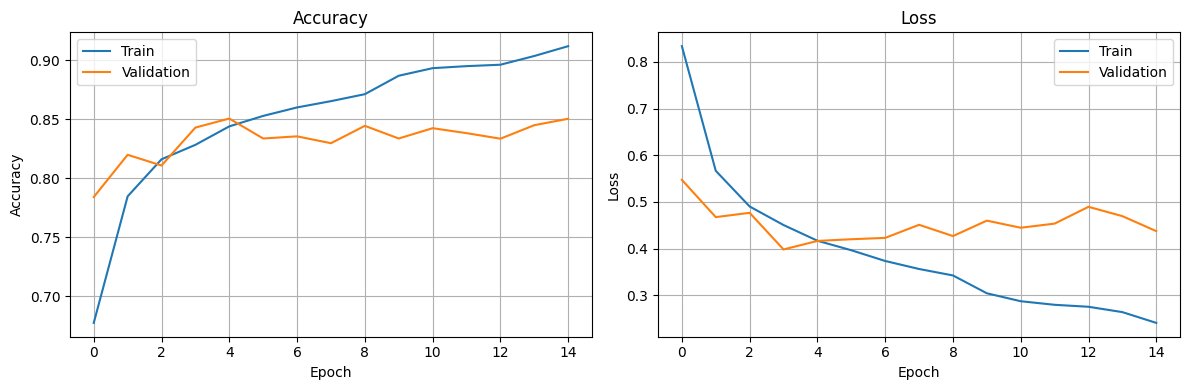

In [51]:
import matplotlib.pyplot as plt

# 绘制训练历史
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()

评估测试集...
测试集准确率: 0.8358
测试集损失: 0.4128


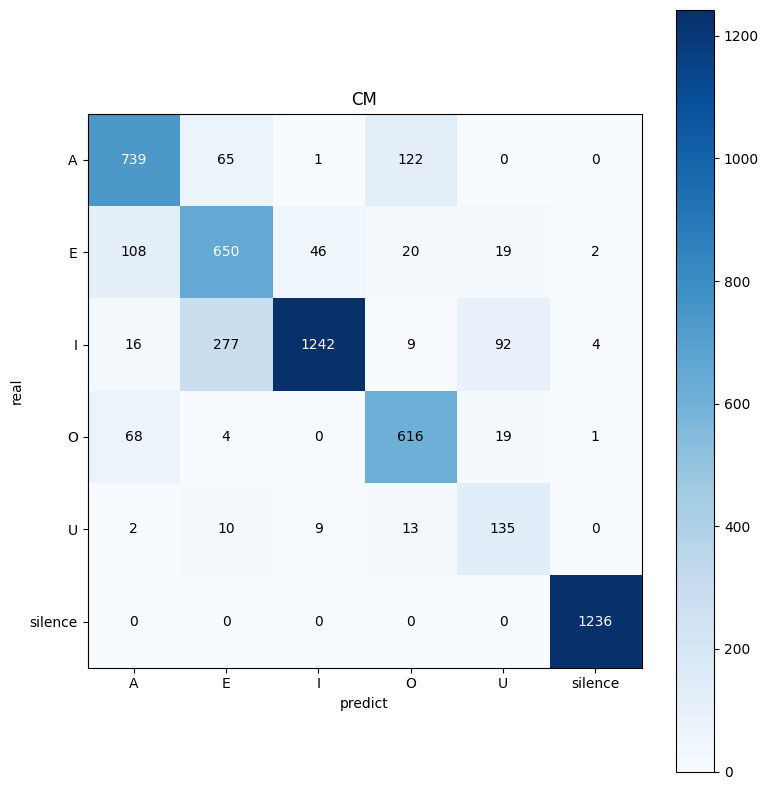


分类报告:
              precision    recall  f1-score   support

           A       0.79      0.80      0.79       927
           E       0.65      0.77      0.70       845
           I       0.96      0.76      0.85      1640
           O       0.79      0.87      0.83       708
           U       0.51      0.80      0.62       169
     silence       0.99      1.00      1.00      1236

    accuracy                           0.84      5525
   macro avg       0.78      0.83      0.80      5525
weighted avg       0.85      0.84      0.84      5525



In [59]:
from sklearn.metrics import confusion_matrix, classification_report

# 评估测试集
print("评估测试集...")
test_loss, test_acc = model.evaluate(test_mel, test_labels, verbose=0)
print(f"测试集准确率: {test_acc:.4f}")
print(f"测试集损失: {test_loss:.4f}")

# 预测
predictions = model.predict(test_mel, verbose=0)
pred_labels = np.argmax(predictions, axis=1)

# 混淆矩阵
cm = confusion_matrix(test_labels, pred_labels)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(NUM_CLASSES),
    yticks=np.arange(NUM_CLASSES),
    xticklabels=VOWEL_CLASSES,
    yticklabels=VOWEL_CLASSES,
    title='CM',
    ylabel='real',
    xlabel='predict'
)

thresh = cm.max() / 2.
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, format(cm[i, j], 'd'),
               ha="center", va="center",
               color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

# 分类报告
print("\n分类报告:")
print(classification_report(test_labels, pred_labels, target_names=VOWEL_CLASSES))

## 9. 导出完整模型

创建包含 Mel 特征提取层的完整模型，然后转换为 TensorFlow.js 格式。

In [53]:
# 创建完整模型（包含 Mel 层）
print("创建完整模型...")
full_model = create_full_model_from_weights(model)

# 测试完整模型
print("\n测试完整模型...")
test_input = test_audio[:5]  # 使用几个测试样本
full_output = full_model.predict(test_input, verbose=0)
print(f"输入形状: {test_input.shape}")
print(f"输出形状: {full_output.shape}")

for i in range(min(5, len(test_input))):
    true_label = VOWEL_CLASSES[test_labels[i]]
    pred_label = VOWEL_CLASSES[np.argmax(full_output[i])]
    conf = np.max(full_output[i])
    print(f"  样本 {i+1}: 真实={true_label}, 预测={pred_label} (置信度={conf:.3f})")

创建完整模型...
Calculated Mel spectrogram time steps: 19

测试完整模型...
输入形状: (5, 3360)
输出形状: (5, 6)
  样本 1: 真实=A, 预测=A (置信度=0.982)
  样本 2: 真实=A, 预测=A (置信度=0.522)
  样本 3: 真实=A, 预测=A (置信度=0.951)
  样本 4: 真实=A, 预测=A (置信度=0.960)
  样本 5: 真实=A, 预测=A (置信度=0.995)


In [54]:
# 保存 Keras 模型
keras_path = os.path.join(OUTPUT_DIR, 'vowel_model.keras')
full_model.save(keras_path)
print(f"Keras 模型已保存: {keras_path}")

# 导出 SavedModel 格式（用于转换）
saved_model_path = os.path.join(OUTPUT_DIR, 'saved_model')
full_model.export(saved_model_path)
print(f"SavedModel 已导出: {saved_model_path}")

Keras 模型已保存: /content/vowel_training/output/vowel_model.keras
Saved artifact at '/content/vowel_training/output/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3360), dtype=tf.float32, name='waveform')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135820538618384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135820538625488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135822036059536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135821630964752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135820538625872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135821630965328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135821630967632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135820538625680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135824067062928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1358216

## 10. 转换为 TensorFlow.js

In [55]:
import subprocess

tfjs_output_path = os.path.join(OUTPUT_DIR, 'tfjs_model')
os.makedirs(tfjs_output_path, exist_ok=True)

# 转换命令
cmd = [
    'tensorflowjs_converter',
    '--input_format=tf_saved_model',
    '--output_format=tfjs_graph_model',
    '--quantize_uint8',
    '--skip_op_check',
    saved_model_path,
    tfjs_output_path
]

print(f"执行转换命令...")
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("\n✅ 转换成功!")

    # 列出输出文件
    print("\n输出文件:")
    total_size = 0
    for f in os.listdir(tfjs_output_path):
        fpath = os.path.join(tfjs_output_path, f)
        size = os.path.getsize(fpath)
        total_size += size
        print(f"  {f}: {size / 1024:.1f} KB")

    print(f"\n总大小: {total_size / 1024:.1f} KB")
else:
    print(f"\n❌ 转换失败!")
    print(f"错误: {result.stderr}")

执行转换命令...

✅ 转换成功!

输出文件:
  group1-shard1of1.bin: 67.6 KB
  model.json: 36.9 KB

总大小: 104.5 KB


## 11. 下载模型

运行下面的 cell 下载 TensorFlow.js 模型文件。

In [56]:
# 打包并下载
import shutil
from google.colab import files

# 打包 tfjs_model 文件夹
zip_path = '/content/tfjs_model.zip'
shutil.make_archive('/content/tfjs_model', 'zip', tfjs_output_path)

print(f"模型已打包: {zip_path}")
print(f"大小: {os.path.getsize(zip_path) / 1024:.1f} KB")

# 下载
files.download(zip_path)

模型已打包: /content/tfjs_model.zip
大小: 56.0 KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# 同时保存到 Google Drive（备份）
drive_output = '/content/drive/MyDrive/vowel_model_output'
os.makedirs(drive_output, exist_ok=True)

# 复制所有输出文件
shutil.copytree(OUTPUT_DIR, os.path.join(drive_output, 'output'), dirs_exist_ok=True)

print(f"\n✅ 所有输出已保存到 Google Drive:")
print(f"   {drive_output}")


✅ 所有输出已保存到 Google Drive:
   /content/drive/MyDrive/vowel_model_output


## 12. JavaScript 使用示例

在浏览器中使用训练好的模型：

In [58]:
js_example = '''
// vowel-detector.js
import * as tf from '@tensorflow/tfjs';

const VOWEL_CLASSES = ['A', 'E', 'I', 'O', 'U', 'silence'];
const INPUT_SAMPLES = 3360; // 210ms @ 16kHz

let model = null;

export async function loadModel(modelPath = '/models/vowel/model.json') {
  model = await tf.loadGraphModel(modelPath);
  console.log('元音识别模型已加载');
  return model;
}

export async function detectVowel(audioBuffer) {
  if (!model) throw new Error('模型未加载');

  // 确保输入长度正确
  let samples = new Float32Array(INPUT_SAMPLES);
  const copyLength = Math.min(audioBuffer.length, INPUT_SAMPLES);
  samples.set(audioBuffer.slice(0, copyLength));

  // 创建 tensor [1, 3360]
  const input = tf.tensor2d([samples], [1, INPUT_SAMPLES]);

  // 推理
  const output = model.predict(input);
  const probs = await output.data();

  // 清理
  input.dispose();
  output.dispose();

  // 返回结果
  const maxIdx = probs.indexOf(Math.max(...probs));
  return {
    vowel: VOWEL_CLASSES[maxIdx],
    confidence: probs[maxIdx],
    probabilities: Object.fromEntries(
      VOWEL_CLASSES.map((v, i) => [v, probs[i]])
    )
  };
}
'''

print("JavaScript 使用示例:")
print("=" * 60)
print(js_example)

JavaScript 使用示例:

// vowel-detector.js
import * as tf from '@tensorflow/tfjs';

const VOWEL_CLASSES = ['A', 'E', 'I', 'O', 'U', 'silence'];
const INPUT_SAMPLES = 3360; // 210ms @ 16kHz

let model = null;

export async function loadModel(modelPath = '/models/vowel/model.json') {
  model = await tf.loadGraphModel(modelPath);
  console.log('元音识别模型已加载');
  return model;
}

export async function detectVowel(audioBuffer) {
  if (!model) throw new Error('模型未加载');

  // 确保输入长度正确
  let samples = new Float32Array(INPUT_SAMPLES);
  const copyLength = Math.min(audioBuffer.length, INPUT_SAMPLES);
  samples.set(audioBuffer.slice(0, copyLength));

  // 创建 tensor [1, 3360]
  const input = tf.tensor2d([samples], [1, INPUT_SAMPLES]);

  // 推理
  const output = model.predict(input);
  const probs = await output.data();

  // 清理
  input.dispose();
  output.dispose();

  // 返回结果
  const maxIdx = probs.indexOf(Math.max(...probs));
  return {
    vowel: VOWEL_CLASSES[maxIdx],
    confidence: probs[maxIdx],
  

---

## 🎉 完成!

你的模型已经训练完成并转换为 TensorFlow.js 格式。

### 下一步
1. 将下载的 `tfjs_model.zip` 解压到你的项目中
2. 使用上面的 JavaScript 代码加载和使用模型
3. 集成到你的 OIIAIOIIIAI 游戏中!

### 文件说明
- `model.json` - 模型结构
- `group1-shard*.bin` - 模型权重
- 总大小约 100KB (量化后)